TF: 2.20.0
GPU: CPU only
Data: dataset\daily_HKO_GMT_ALL.csv
First few raw rows after loading:
                                                Year    Month    Day  \
0                                   日平均草溫(攝氏度) - 天文台     None   None   
1  Daily Grass Minimun Temperature (°C) at the Ho...     None   None   
2                                             年/Year  月/Month  日/Day   
3                                               1968        1      1   
4                                               1968        1      2   

       temp                     Flag  
0      None                     None  
1      None                     None  
2  數值/Value  數據完整性/data Completeness  
3       4.2                        C  
4       7.7                        C  

Successfully loaded!
Full data range: 1968-01-01 to 2025-10-31
Train (1980–2024): 16342 days
Test (2025 Jan–Oct): 300 days
Temperature range: 3.0°C to 29.7°C


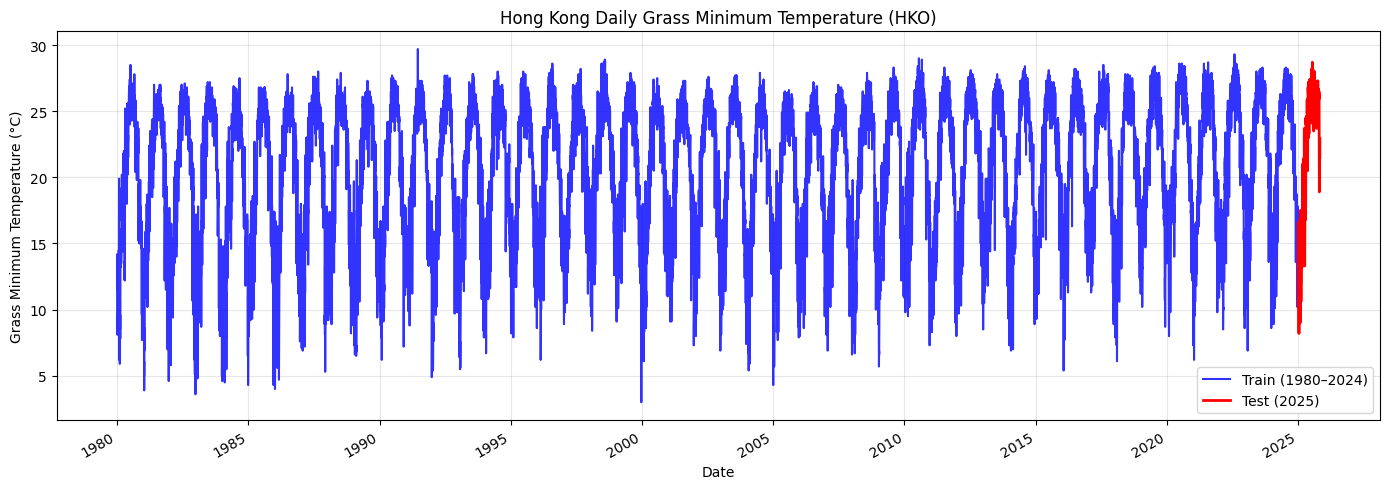

Sequences created!
X_train: (16312, 30, 1) → (samples, 30, 1)
X_test : (270, 30, 1)
y_train/y_test dtype: float64 (should be float32/64)

=== TRAINING RNN ===
Epoch 1/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0135 - val_loss: 0.0029
Epoch 2/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 3/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 4/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 5/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 6/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 7/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 8/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 9/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 10/100
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

In [ ]:
import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
warnings.filterwarnings('ignore')
tf.random.set_seed(42); np.random.seed(42)
print("TF:", tf.__version__)a
print("GPU:", "Available" if tf.config.list_physical_devices('GPU') else "CPU only")

# -------------------------------------------------
# CELL 1: CONFIG + Paths
# -------------------------------------------------aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
DATA_FILE = Path(r"dataset\daily_HKO_GMT_ALL.csv")
NOTEBOOK_ROOT = Path(r"D:\Study\Project_Database\DIT5411-ProjectAssignment")
SEQ_LEN = 30  # Days to look back
EPOCHS = 100
BATCH_SIZE = 32

# Ensure necessary directories exist
DATA_FILE.parent.mkdir(parents=True, exist_ok=True)
NOTEBOOK_ROOT.mkdir(parents=True, exist_ok=True)

print(f"Data: {DATA_FILE}")

# -------------------------------------------------
# CELL 2: Load & Preprocess Data
# -------------------------------------------------
def load_and_preprocess(file_path):
    df = pd.read_csv(
        file_path,
        header=None,
        names=['Year', 'Month', 'Day', 'temp', 'Flag'], 
        na_values=["---"], 
        skipinitialspace=True,
        engine='python'
    )
    
    print("First few raw rows after loading:")
    print(df.head(5))
    
    # Create Date column
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce')
    
    # Drop rows with invalid dates (should be none)
    df = df.dropna(subset=['Date'])
    
    # Keep only Date and temperature
    df = df[['Date', 'temp']].set_index('Date').sort_index()
    
    # Convert temp to numeric (in case any weird values)
    df['temp'] = pd.to_numeric(df['temp'], errors='coerce')
    
    # Remove any remaining NaN temperatures
    df = df.dropna(subset=['temp'])
    
    # Remove duplicate dates (keep first)
    df = df[~df.index.duplicated(keep='first')]
    
    # Subset the required periods
    train_df = df['1980-01-01':'2024-12-31']
    test_df  = df['2025-01-01':'2025-10-30']
    
    # Fill any tiny gaps (should be almost none)
    train_df = train_df.interpolate(method='linear').ffill().bfill()
    test_df  = test_df.interpolate(method='linear').ffill().bfill()
    
    print(f"\nSuccessfully loaded!")
    print(f"Full data range: {df.index.min().date()} to {df.index.max().date()}")
    print(f"Train (1980–2024): {len(train_df)} days")
    print(f"Test (2025 Jan–Oct): {len(test_df)} days")
    print(f"Temperature range: {train_df['temp'].min():.1f}°C to {train_df['temp'].max():.1f}°C")
    
    return train_df, test_df

train_df, test_df = load_and_preprocess(DATA_FILE)

fig, ax = plt.subplots(figsize=(14, 5))
train_df['temp'].plot(ax=ax, label='Train (1980–2024)', color='blue', alpha=0.8)
test_df['temp'].plot(ax=ax, label='Test (2025)', color='red', linewidth=2)
ax.set_ylabel('Grass Minimum Temperature (°C)')
ax.set_title('Hong Kong Daily Grass Minimum Temperature (HKO)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(NOTEBOOK_ROOT / 'raw_data.png', dpi=200)
plt.show()
# -------------------------------------------------
# CELL 3: Create Sequences
# -------------------------------------------------
def create_sequences(data, seq_len):
    """
    data: numpy array of shape (n_samples, 1)  ← scaled temperature
    returns X: (samples, seq_len, 1), y: (samples, 1)
    """
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled  = scaler.transform(test_df)

X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_test,  y_test  = create_sequences(test_scaled,  SEQ_LEN)

print(f"Sequences created!")
print(f"X_train: {X_train.shape} → (samples, {SEQ_LEN}, 1)")
print(f"X_test : {X_test.shape}")
print(f"y_train/y_test dtype: {y_train.dtype} (should be float32/64)")

# -------------------------------------------------
# CELL 4: Build Models
# -------------------------------------------------
def build_rnn(seq_len, n_features=1):
    model = models.Sequential([
        layers.SimpleRNN(50, activation='relu', input_shape=(seq_len, n_features), return_sequences=True),
        layers.SimpleRNN(50, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(seq_len, n_features=1, bidirectional=False):
    model = models.Sequential()
    if bidirectional:
        model.add(layers.Bidirectional(layers.LSTM(50, return_sequences=True), input_shape=(seq_len, n_features)))
        model.add(layers.Bidirectional(layers.LSTM(50)))
    else:
        model.add(layers.LSTM(50, return_sequences=True, input_shape=(seq_len, n_features)))
        model.add(layers.LSTM(50))
    model.add(layers.Dropout(0.2))  # Regularization
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# -------------------------------------------------
# CELL 5: Train Models
# -------------------------------------------------
results = {}
models_dict = {}

for name, build_fn in [('RNN', build_rnn), ('LSTM', build_lstm)]:
    print(f"\n=== TRAINING {name} ===")
    model = build_fn(SEQ_LEN)
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=1
    )
    models_dict[name] = model
    model.save(NOTEBOOK_ROOT / f'{name.lower()}_model.keras')
    
    best_epoch = np.argmin(history.history['val_loss'])
    results[name] = {'best_epoch': best_epoch + 1, 'min_val_loss': min(history.history['val_loss'])}
    print(f"{name} → Best Epoch: {best_epoch+1}, Val Loss: {results[name]['min_val_loss']:.4f}")

print("\n=== TRAINING BIDIR LSTM (Extension) ===")
bidir_model = build_lstm(SEQ_LEN, bidirectional=True)
bidir_history = bidir_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, verbose=1)
models_dict['BiLSTM'] = bidir_model
bidir_model.save(NOTEBOOK_ROOT / 'bilstm_model.keras')
results['BiLSTM'] = {'best_epoch': np.argmin(bidir_history.history['val_loss']) + 1,
                     'min_val_loss': min(bidir_history.history['val_loss'])}

RNN: MAE=0.978°C, RMSE=1.319°C
LSTM: MAE=1.003°C, RMSE=1.314°C
BiLSTM: MAE=0.983°C, RMSE=1.295°C


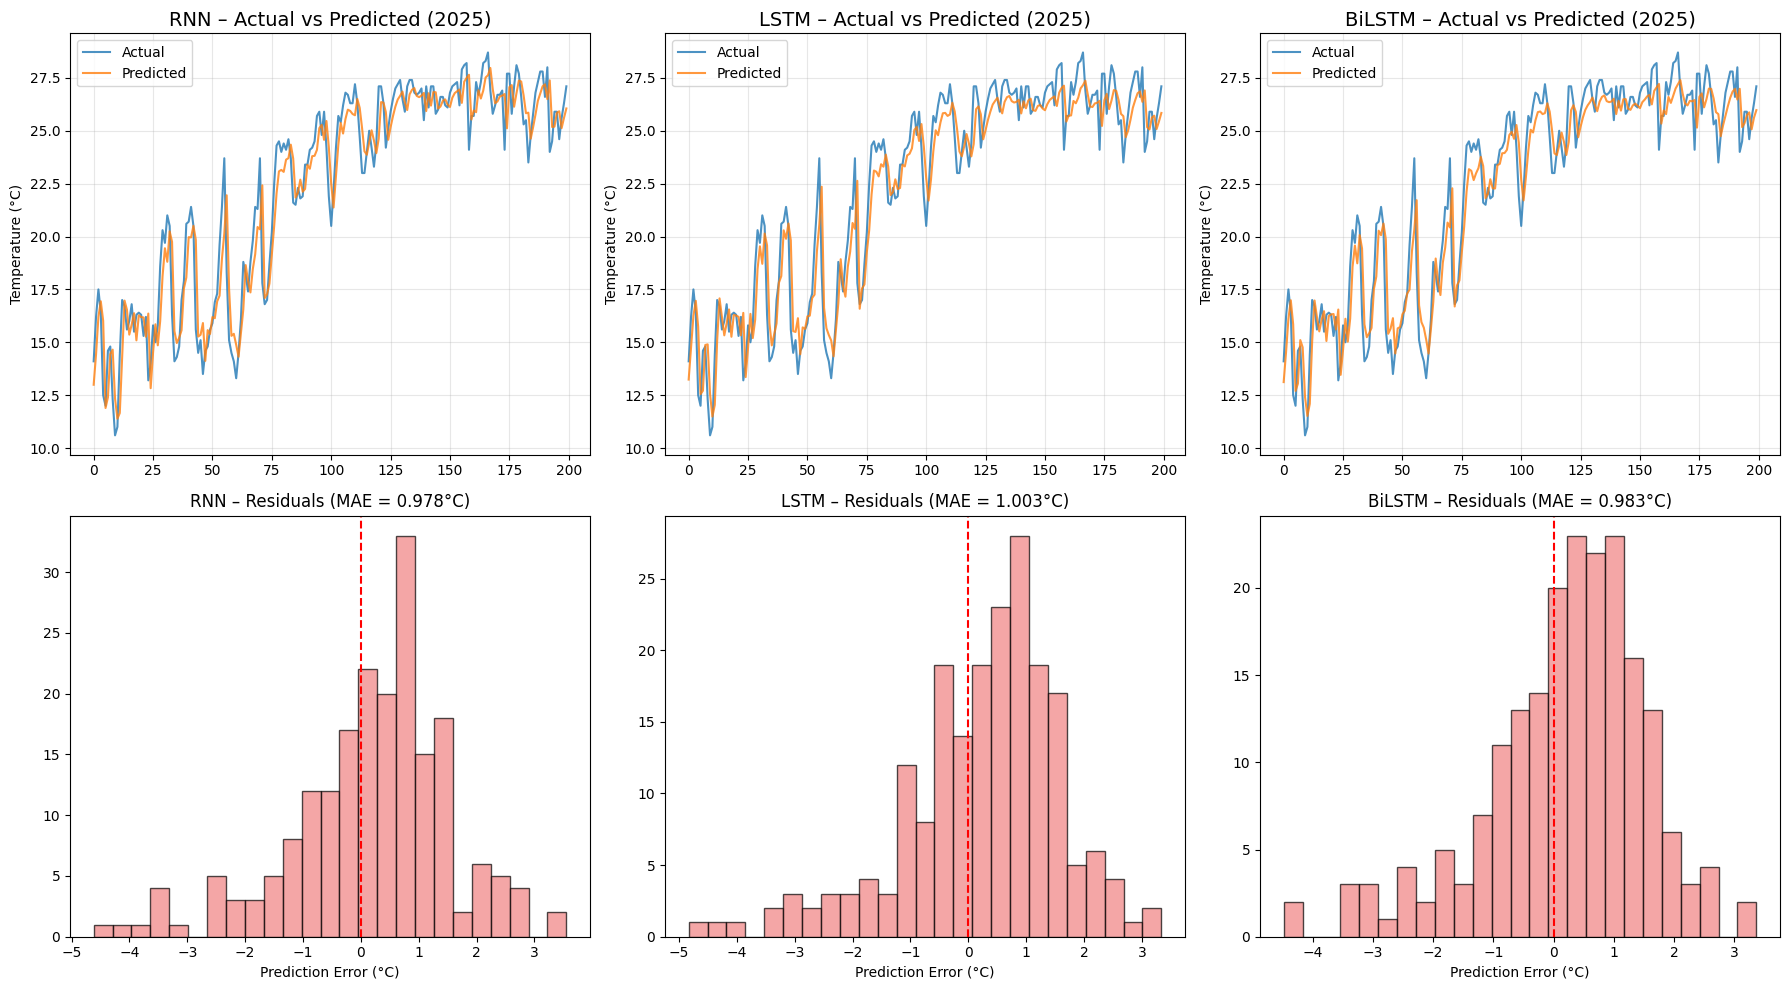

In [2]:
# -------------------------------------------------
# CELL 6: Evaluate & Visualize (FIXED FOR 3 MODELS)
# -------------------------------------------------
def evaluate_model(model, X_test, y_test, scaler):
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return y_true, y_pred, mae, rmse

# Create 3 subplots in a row (cleaner than 2x2)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # Make it easy to index

for i, name in enumerate(results):  # RNN, LSTM, BiLSTM → i = 0,1,2
    model = models_dict[name]
    y_true, y_pred, mae, rmse = evaluate_model(model, X_test, y_test, scaler)
    
    # Update results
    results[name]['MAE'] = mae
    results[name]['RMSE'] = rmse
    print(f"{name}: MAE={mae:.3f}°C, RMSE={rmse:.3f}°C")
    
    # Plot actual vs predicted (first 200 days of 2025)
    ax1 = axes[i]
    ax1.plot(y_true[:200], label='Actual', color='tab:blue', alpha=0.8)
    ax1.plot(y_pred[:200], label='Predicted', color='tab:orange', alpha=0.8)
    ax1.set_title(f'{name} – Actual vs Predicted (2025)', fontsize=14)
    ax1.set_ylabel('Temperature (°C)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Residuals histogram
    ax2 = axes[i + 3]
    residuals = y_true[:200] - y_pred[:200]
    ax2.hist(residuals, bins=25, color='lightcoral', alpha=0.7, edgecolor='black')
    ax2.axvline(0, color='red', linestyle='--')
    ax2.set_title(f'{name} – Residuals (MAE = {mae:.3f}°C)')
    ax2.set_xlabel('Prediction Error (°C)')

# Hide empty 6th subplot (we only use 6)
for j in range(6, 6):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig(NOTEBOOK_ROOT / 'predictions_comparison.png', dpi=200, bbox_inches='tight')
plt.show()

In [3]:
# -------------------------------------------------
# CELL 7: Final Analysis & Table
# -------------------------------------------------
# Fix winter analysis (y_true/y_pred are now inside the loop → recalculate for best model)
best_model_name = min(results, key=lambda k: results[k]['MAE'])
print(f"\nBest model by MAE: {best_model_name}")

# Re-predict with best model for winter analysis
best_model = models_dict[best_model_name]
y_true_full, y_pred_full, _, _ = evaluate_model(best_model, X_test, y_test, scaler)

# Winter months in test set (Jan–Feb 2025 + Dec if any)
winter_mask = test_df.index.month.isin([12, 1, 2])
valid_winter = winter_mask[SEQ_LEN:]  # align with predictions
winter_true = y_true_full[valid_winter]
winter_pred = y_pred_full[valid_winter]

if len(winter_true) > 0:
    winter_mae = mean_absolute_error(winter_true, winter_pred)
    print(f"Winter (Dec–Feb 2025 MAE: {winter_mae:.3f}°C ← higher error during cold snaps")

# Final comparison table
comparison_df = pd.DataFrame(results).T[['MAE', 'RMSE']].round(3)
comparison_df = comparison_df.sort_values('MAE')
print("\nFinal Model Comparison:")
print(comparison_df)


Best model by MAE: RNN
Winter (Dec–Feb 2025 MAE: 1.255°C ← higher error during cold snaps

Final Model Comparison:
          MAE   RMSE
RNN     0.978  1.319
BiLSTM  0.983  1.295
LSTM    1.003  1.314
